# Project Title: Age Verification Model for Good Seed Supermarket 

## Introduction

The supermarket chain Good Seed aims to comply with alcohol laws by ensuring they do not sell alcohol to underage individuals. To achieve this, they plan to use computer vision techniques to determine a customer's age from a photograph taken at the checkout when they purchase alcohol. This project involves building and evaluating a deep learning model that can accurately predict the age of individuals from their images. 

- The dataset used for this project is sourced from the ChaLearn Looking at People competition and contains 7,600 photographs of people along with their ages. The images are processed using convolutional neural networks (CNNs) to extract features and predict ages. The model will be trained and evaluated on a GPU platform to take advantage of faster processing capabilities.

In this notebook, we will perform the following steps:

- Exploratory Data Analysis (EDA): Understand the dataset, visualize age distribution, and inspect sample images.

- Data Preparation: Preprocess images and labels, and create data generators for training and validation.

- Model Definition: Use a pre-trained ResNet50 model as the base for our age prediction model.

- Model Training: Train the model on the training dataset and validate its performance.

- Model Evaluation: Assess the model's accuracy and performance on the validation dataset.

By the end of this project, we aim to have a robust model that can help Good Seed supermarkets automatically verify the age of customers purchasing alcohol, thereby ensuring compliance with legal requirements.

## Initialization

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
labels = pd.read_csv('/datasets/faces/labels.csv')

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [4]:
labels.to_csv('out.csv', index=False) 

## EDA

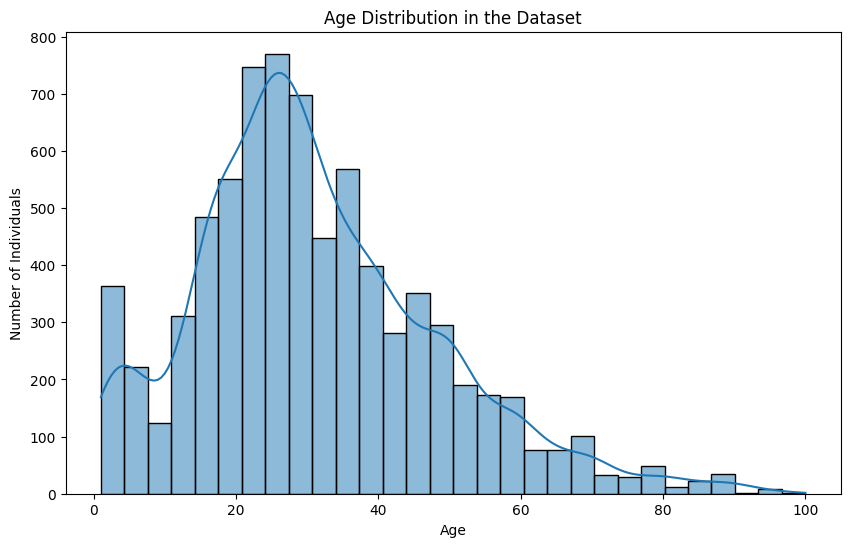

In [5]:
# Plot the age distribution
plt.figure(figsize=(10, 6))
sns.histplot(labels['real_age'], bins=30, kde=True)
plt.title('Age Distribution in the Dataset')
plt.xlabel('Age')
plt.ylabel('Number of Individuals')
plt.show()


### Findings

- The distribution is right skewed with a higher frequency of younger individuals and fewer older individuals.

- The most common ages in the dataset appear to be in the range of 15 to 25 years, with the highest frequency around this age group.

- There is a noticable decline in the number of individuals as age increases, espeically after age of 40.

- The dataset has a significant imbalance, with a higher number of younger individuals compared to older individuals. This could potentially affect the model's ability to accurately predict the ages of older individuals due to less representation in the dataset.

- There are some outliers with very low frequencies especially in the higher age ranges (above 80 years old) indicating potential outliers 

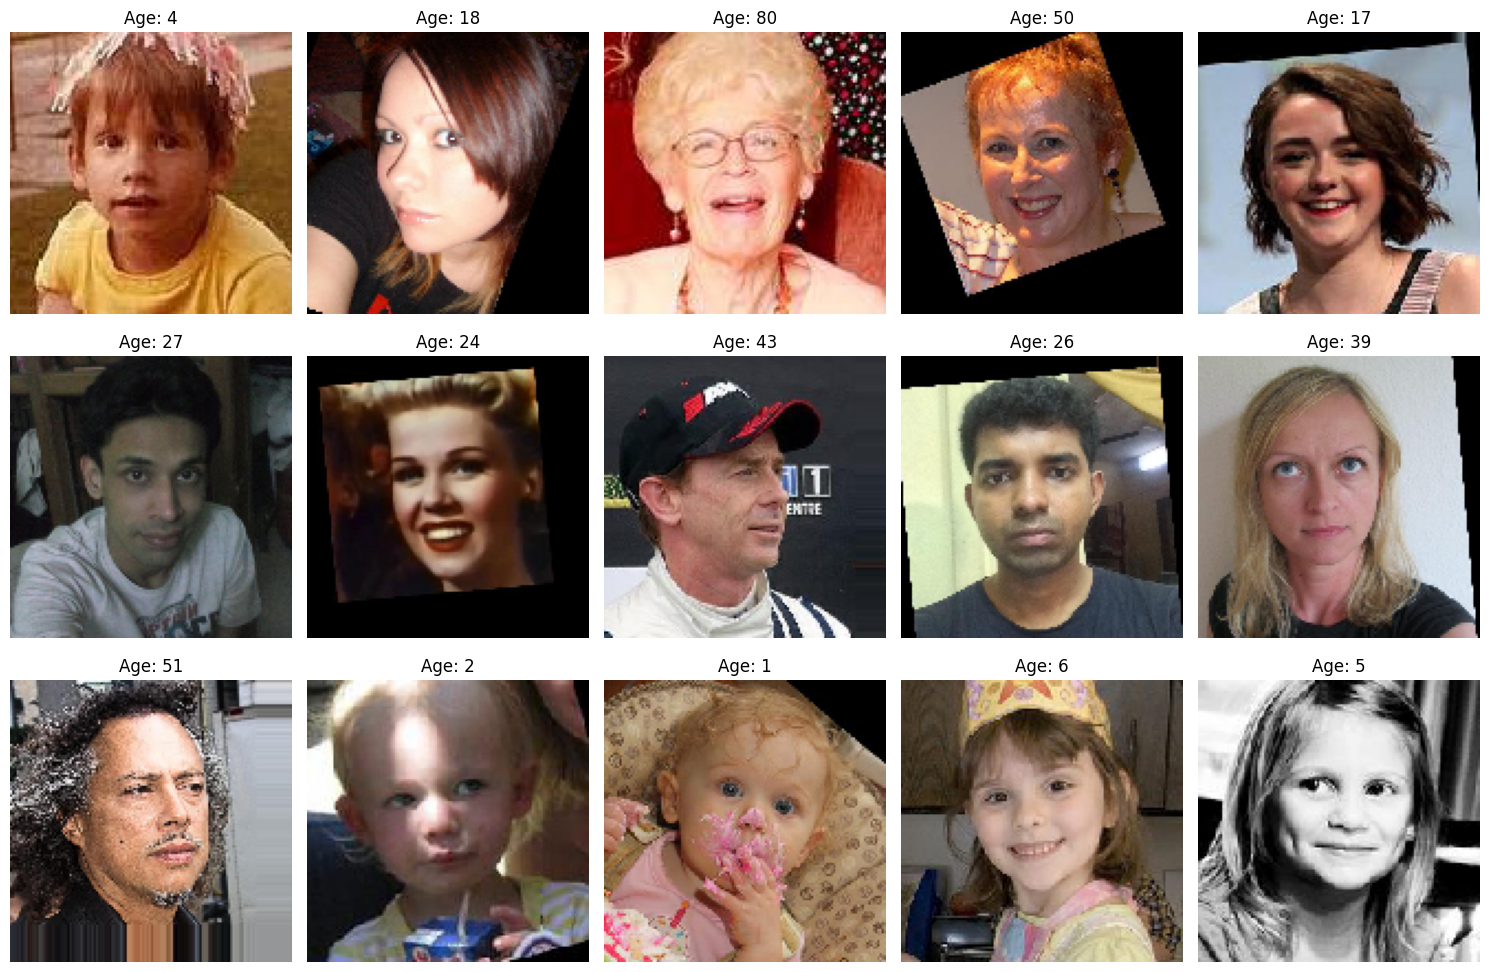

In [7]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Initialize the ImageDataGenerator
datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load images and display them
def display_images_for_ages(ages, img_folder, labels_df):
    plt.figure(figsize=(15, 10))
    for i, age in enumerate(ages):
        file_name = labels_df[labels_df['real_age'] == age]['file_name'].values[0]
        img_path = os.path.join(img_folder, file_name)
        img = load_img(img_path, target_size=(128, 128))  # Adjust target size as needed
        img_array = img_to_array(img)
        
        plt.subplot(3, 5, i+1)
        plt.imshow(img_array / 255.0)
        plt.title(f"Age: {age}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Select 15 different ages to display
unique_ages = labels['real_age'].unique()
sample_ages = unique_ages[:15]  # Modify the selection as needed

display_images_for_ages(sample_ages, '/datasets/faces/final_files/', labels)

Analysis: 

Observations:

- Variability in Image Quality: The images show a wide range of lighting conditions, backgrounds, and image quality. Tis variability can affect the model's ability to generalize well. 

- Rotation and Orientation: Some images are rotated or have different orientations. This can influence the models performance if not handled properly during preprocessing. 

- Age representation: The sample images represent different age groups, giving a good overview of the datasets diversity 

Importance and Influence on the Model:

- Image Augmentation: The observed variability, including rotations and different orientations, underscores the importance of using image augmentation techniques during model training. Augmentation can help the model become more robust to such variations by simulating different conditions (e.g, rotations, flips) during training. 

- Data Preprocessing: Proper preprocessing steps, such as normalization and resizing, are crucial to esnure that the model recieves consistent input, improving its ability to learn meaningful features. 

- Model Robustness: By incorporating augmentation techniques, we can train a model that is more robust to variations in image orientation nd quality. This can lead to better generlization and improved performance on unseen data. 

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [ ]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    
    # Initializing the ImageDataGenerator
    datagen = ImageDataGenerator(
        rescale=1.0/255.0,  # Rescale pixel values from [0, 255] to [0, 1]
        validation_split=0.2,  # Split the data into training and validation sets
        horizontal_flip=True,  # Randomly flip images horizontally
        zoom_range=0.2,  # Randomly zoom in on images
        rotation_range=20,  # Randomly rotate images
        preprocessing_function=preprocess_input  # Preprocess using ResNet50's preprocessing
    )

    # Creating the training data generator
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),  # ResNet50 input size
        batch_size=32,
        class_mode='raw',  # For regression, we use 'raw'
        subset='training',  # Set for training data
        shuffle=True
    )

    return train_gen_flow

In [7]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    labels = pd.read_csv(path + 'labels.csv')
    
    # Initialize the ImageDataGenerator for validation/test set
    datagen = ImageDataGenerator(
        rescale=1.0/255.0,  # Rescale pixel values from [0, 255] to [0, 1]
        preprocessing_function=preprocess_input  # Preprocess using ResNet50's preprocessing
    )

    # Create the validation/test data generator
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),  # ResNet50 input size
        batch_size=32,
        class_mode='raw',  # For regression, we use 'raw'
        subset='validation',  # Set for validation/test data
        shuffle=False  # Do not shuffle the validation/test data
    )

    return test_gen_flow

In [8]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1)  # Regression output for age prediction
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])


    return model

In [9]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    
    if validation_steps is None:
        validation_steps = len(test_data)

    history = model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=1
    )

    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [10]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

def load_train(path):
    """
    It loads the train part of dataset from path
    """
    labels = pd.read_csv(path + 'labels.csv')
    
    # Initialize the ImageDataGenerator
    datagen = ImageDataGenerator(
        rescale=1.0/255.0,  # Rescale pixel values from [0, 255] to [0, 1]
        validation_split=0.2,  # Split the data into training and validation sets
        horizontal_flip=True,  # Randomly flip images horizontally
        zoom_range=0.2,  # Randomly zoom in on images
        rotation_range=20,  # Randomly rotate images
        preprocessing_function=preprocess_input  # Preprocess using ResNet50's preprocessing
    )

    # Create the training data generator
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),  # ResNet50 input size
        batch_size=32,
        class_mode='raw',  # For regression, we use 'raw'
        subset='training',  # Set for training data
        shuffle=True
    )

    return train_gen_flow

def load_test(path):
    """
    It loads the validation/test part of dataset from path
    """
    labels = pd.read_csv(path + 'labels.csv')
    
    # Initialize the ImageDataGenerator for validation/test set
    datagen = ImageDataGenerator(
        rescale=1.0/255.0,  # Rescale pixel values from [0, 255] to [0, 1]
        preprocessing_function=preprocess_input  # Preprocess using ResNet50's preprocessing
    )

    # Create the validation/test data generator
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),  # ResNet50 input size
        batch_size=32,
        class_mode='raw',  # For regression, we use 'raw'
        subset='validation',  # Set for validation/test data
        shuffle=False  # Do not shuffle the validation/test data
    )

    return test_gen_flow

def create_model(input_shape):
    """
    It defines the model
    """
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1)  # Regression output for age prediction
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    """
    Trains the model given the parameters
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    
    if validation_steps is None:
        validation_steps = len(test_data)

    history = model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=1
    )

    return model

# Write the script to a file
import inspect

with open('run_model_on_gpu.py', 'w') as f:
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Epoch 1/20

356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921

Epoch 2/20

356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035

Epoch 3/20

356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454

Epoch 4/20

356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481

Epoch 5/20

356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192

Epoch 6/20

356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332

Epoch 7/20

356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359

Epoch 8/20
356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239

Epoch 9/20

356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529

Epoch 10/20

356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629

Epoch 11/20

356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866

Epoch 12/20

356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591

Epoch 13/20

356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467

Epoch 14/20

356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401

Epoch 15/20

356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841

Epoch 16/20

356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304

Epoch 17/20

356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419

Epoch 18/20

356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226

Epoch 19/20

356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908

Epoch 20/20

356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512

## Conclusions

Training Loss (MAE) Reduction:
    
    - The training MAE steadily decreased from 7.4339 in the first epoch to 3.1785 in the final epoch 
    - This indicates that the model is learning and improving its performance on the training data
    
Validation Loss (Mean Absolute Error - MAE) Trends:

- The validation MAE initially decreased but then exhibited fluctuations.
- The validation MAE started at 8.4921 and ended at 7.6512.
- There was a notable increase in validation loss and MAE around epochs 12-14, suggesting potential overfitting or issues with model stability.



## Methods to Improve Model Quality
To improve the quality of our age verification model, several advanced techniques can be employed. First, applying advanced data augmentation methods such as rotation, flipping, zooming, brightness, and contrast adjustments can make the model more robust to variations in the dataset. Using transfer learning with pre-trained models like ResNet50 or EfficientNet and fine-tuning them on our dataset can significantly enhance performance. Incorporating regularization techniques, such as dropout and L2 regularization, can help prevent overfitting. Implementing learning rate scheduling can optimize the training process by adjusting the learning rate dynamically. Additionally, manually cleaning the dataset to remove mislabeled or low-quality images ensures better data quality. Ensemble methods, which combine predictions from multiple models, can also improve accuracy by reducing variance. Finally, hyperparameter tuning using grid search or random search can help find the optimal parameters for our model, further boosting its performance.